In [1]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

train_dataset = DataClass(split='train', download=download, transform=transform)
val_dataset = DataClass(split='val', download=download, transform=transform)
test_dataset = DataClass(split='test', download=download, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


In [3]:
from torch.utils.data import ConcatDataset

# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Create a new DataLoader for the combined dataset
combined_train_loader = DataLoader(dataset=combined_train_dataset, batch_size=128, shuffle=True, drop_last=True)

In [4]:
from sklearn.model_selection import StratifiedKFold

# Create stratified K-fold cross-validator
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the labels for stratification
labels = [label for _, label in combined_train_dataset]

# Create a list to store the new dataloaders
train_loaders = []
val_loaders = []

for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
    train_subset = torch.utils.data.Subset(combined_train_dataset, train_index)
    val_subset = torch.utils.data.Subset(combined_train_dataset, val_index)
    
    train_loader = DataLoader(dataset=train_subset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=128, shuffle=False, drop_last=True)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

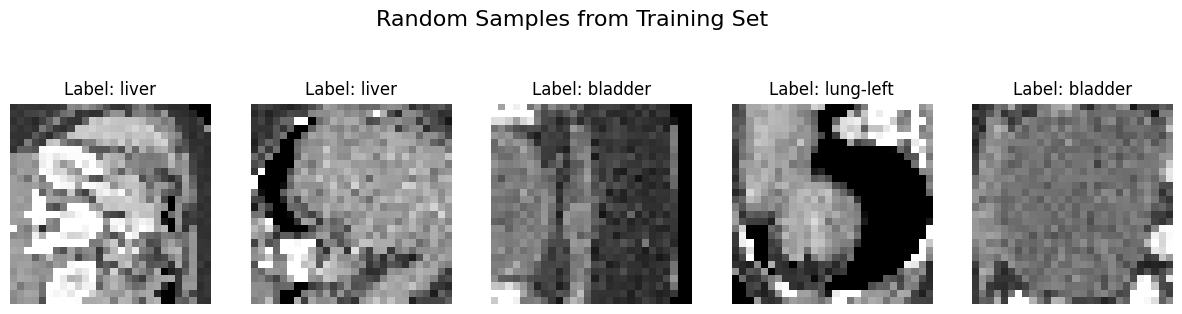

In [5]:
import random

# Function to display images
def show_images(images, labels, title=None):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 4))
    if title:
        fig.suptitle(title, fontsize=16)
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Get 5 random samples from the training set
indices = random.sample(range(len(train_dataset)), 5)
images, labels = zip(*[train_dataset[i] for i in indices])

# Convert images to numpy arrays
images = [image.numpy().transpose(1, 2, 0) for image in images]
labels = [info['label'][str(label.item())] for label in labels]

# Display the images with labels
show_images(images, labels, title='Random Samples from Training Set')

In [ ]:
# ResNet18 training using full dataset
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

num_classes = len(info['label'])

/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = ResNet18(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Training settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.squeeze().long())
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target.squeeze().long()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n')

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    validate(model, device, val_loader, criterion)
    
# Evaluate the model
model.eval()
y_true = []
y_score = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        y_true.extend(target.cpu().numpy().flatten())
        y_score.extend(output.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_score)
print(f'AUC: {auc:.3f}, Accuracy: {acc:.3f}')

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_score.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the trained model
model_path = 'resnet18_organamnist.pt'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model training n0
Train Epoch: 1 [0/32841 (0%)]	Loss: 2.629126
Train Epoch: 1 [1280/32841 (4%)]	Loss: 0.599853
Train Epoch: 1 [2560/32841 (8%)]	Loss: 0.226578
Train Epoch: 1 [3840/32841 (12%)]	Loss: 0.298297
Train Epoch: 1 [5120/32841 (16%)]	Loss: 0.268935
Train Epoch: 1 [6400/32841 (20%)]	Loss: 0.398476
Train Epoch: 1 [7680/32841 (23%)]	Loss: 0.137364
Train Epoch: 1 [8960/32841 (27%)]	Loss: 0.176294
Train Epoch: 1 [10240/32841 (31%)]	Loss: 0.226167
Train Epoch: 1 [11520/32841 (35%)]	Loss: 0.228037
Train Epoch: 1 [12800/32841 (39%)]	Loss: 0.154590
Train Epoch: 1 [14080/32841 (43%)]	Loss: 0.123927
Train Epoch: 1 [15360/32841 (47%)]	Loss: 0.200844
Train Epoch: 1 [16640/32841 (51%)]	Loss: 0.160316
Train Epoch: 1 [17920/32841 (55%)]	Loss: 0.138612
Train Epoch: 1 [19200/32841 (59%)]	Loss: 0.066981
Train Epoch: 1 [20480/32841 (62%)]	Loss: 0.154410
Train Epoch: 1 [21760/32841 (66%)]	Loss: 0.114541
Train Epoch: 1 [23040/32841 (70%)]	Loss: 0.140702
Train Epoch: 1 [24320/32841 (74%)]	Loss: 0.237

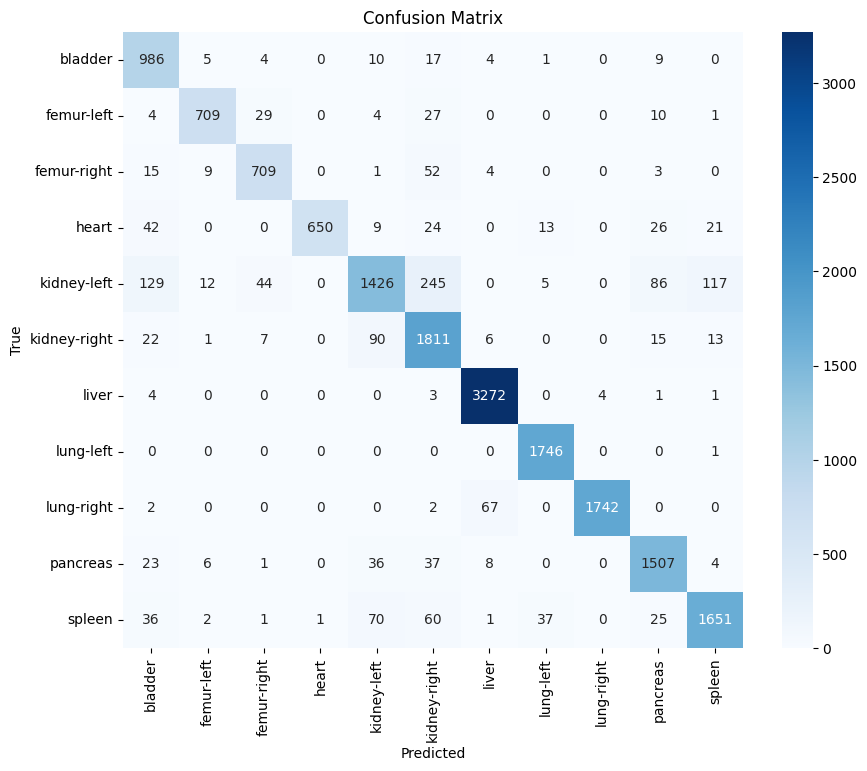

Model saved to resnet18_organamnist0.pt
model training n1


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/32841 (0%)]	Loss: 2.693382
Train Epoch: 1 [1280/32841 (4%)]	Loss: 0.693895
Train Epoch: 1 [2560/32841 (8%)]	Loss: 0.332279
Train Epoch: 1 [3840/32841 (12%)]	Loss: 0.246250
Train Epoch: 1 [5120/32841 (16%)]	Loss: 0.199929
Train Epoch: 1 [6400/32841 (20%)]	Loss: 0.108679
Train Epoch: 1 [7680/32841 (23%)]	Loss: 0.214389
Train Epoch: 1 [8960/32841 (27%)]	Loss: 0.207960
Train Epoch: 1 [10240/32841 (31%)]	Loss: 0.087391
Train Epoch: 1 [11520/32841 (35%)]	Loss: 0.143189
Train Epoch: 1 [12800/32841 (39%)]	Loss: 0.194307
Train Epoch: 1 [14080/32841 (43%)]	Loss: 0.167331
Train Epoch: 1 [15360/32841 (47%)]	Loss: 0.177786
Train Epoch: 1 [16640/32841 (51%)]	Loss: 0.172013
Train Epoch: 1 [17920/32841 (55%)]	Loss: 0.174954
Train Epoch: 1 [19200/32841 (59%)]	Loss: 0.052636
Train Epoch: 1 [20480/32841 (62%)]	Loss: 0.220262
Train Epoch: 1 [21760/32841 (66%)]	Loss: 0.120422
Train Epoch: 1 [23040/32841 (70%)]	Loss: 0.113266
Train Epoch: 1 [24320/32841 (74%)]	Loss: 0.099720
Train Epoch: 1

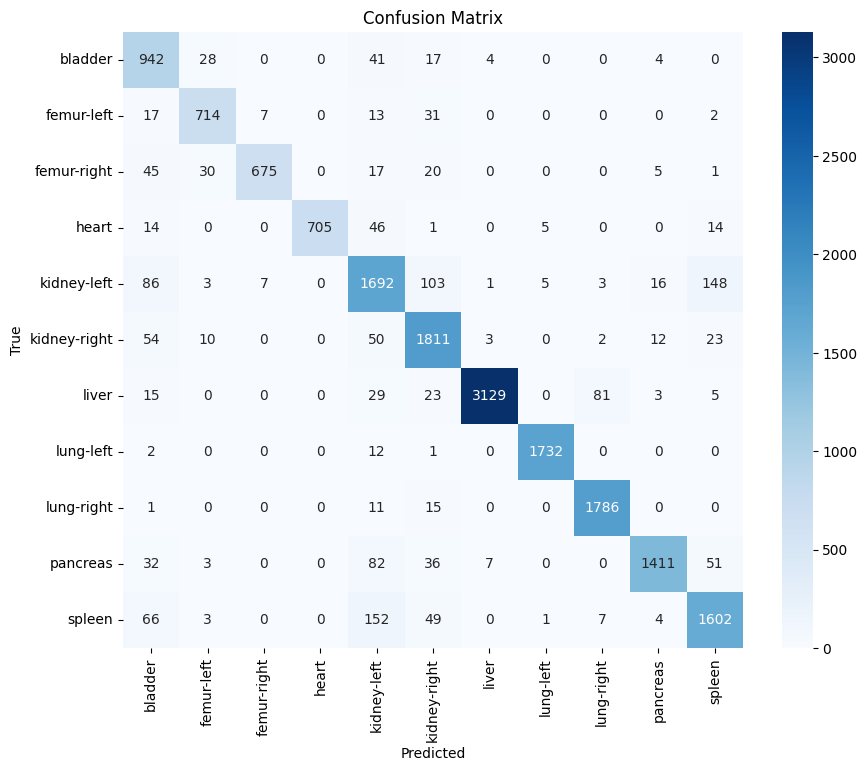

Model saved to resnet18_organamnist1.pt
model training n2


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/32842 (0%)]	Loss: 2.807271
Train Epoch: 1 [1280/32842 (4%)]	Loss: 0.532831
Train Epoch: 1 [2560/32842 (8%)]	Loss: 0.383094
Train Epoch: 1 [3840/32842 (12%)]	Loss: 0.293032
Train Epoch: 1 [5120/32842 (16%)]	Loss: 0.297316
Train Epoch: 1 [6400/32842 (20%)]	Loss: 0.421447
Train Epoch: 1 [7680/32842 (23%)]	Loss: 0.223578
Train Epoch: 1 [8960/32842 (27%)]	Loss: 0.276964
Train Epoch: 1 [10240/32842 (31%)]	Loss: 0.197949
Train Epoch: 1 [11520/32842 (35%)]	Loss: 0.092732
Train Epoch: 1 [12800/32842 (39%)]	Loss: 0.144671
Train Epoch: 1 [14080/32842 (43%)]	Loss: 0.143223
Train Epoch: 1 [15360/32842 (47%)]	Loss: 0.195243
Train Epoch: 1 [16640/32842 (51%)]	Loss: 0.050739
Train Epoch: 1 [17920/32842 (55%)]	Loss: 0.108080
Train Epoch: 1 [19200/32842 (59%)]	Loss: 0.094674
Train Epoch: 1 [20480/32842 (62%)]	Loss: 0.113109
Train Epoch: 1 [21760/32842 (66%)]	Loss: 0.107670
Train Epoch: 1 [23040/32842 (70%)]	Loss: 0.129115
Train Epoch: 1 [24320/32842 (74%)]	Loss: 0.086683
Train Epoch: 1

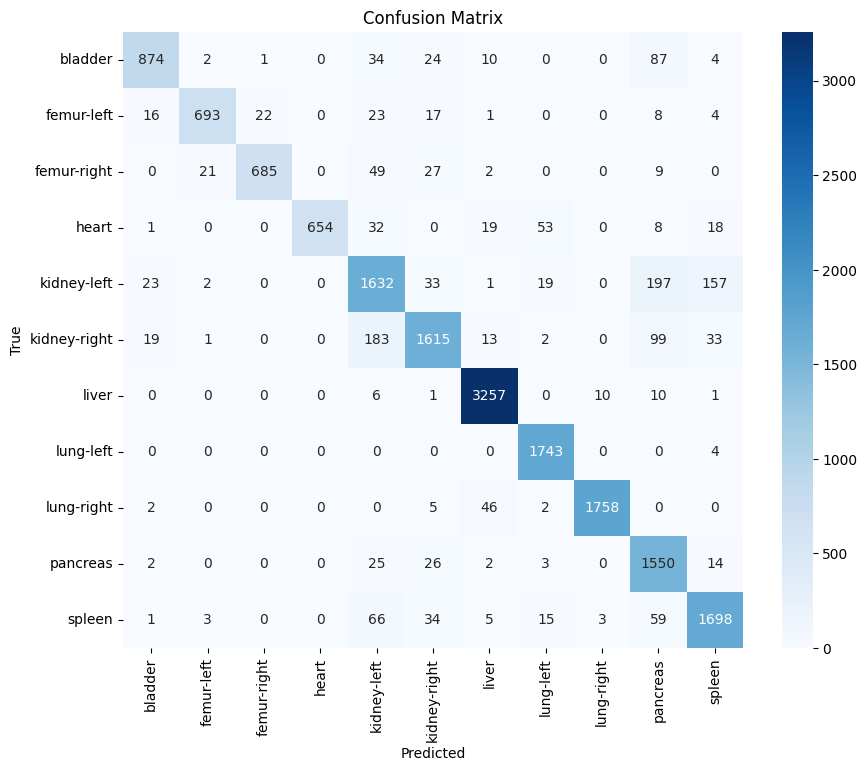

Model saved to resnet18_organamnist2.pt
model training n3


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/32842 (0%)]	Loss: 2.458519
Train Epoch: 1 [1280/32842 (4%)]	Loss: 0.523270
Train Epoch: 1 [2560/32842 (8%)]	Loss: 0.298075
Train Epoch: 1 [3840/32842 (12%)]	Loss: 0.274102
Train Epoch: 1 [5120/32842 (16%)]	Loss: 0.150274
Train Epoch: 1 [6400/32842 (20%)]	Loss: 0.264457
Train Epoch: 1 [7680/32842 (23%)]	Loss: 0.237337
Train Epoch: 1 [8960/32842 (27%)]	Loss: 0.217251
Train Epoch: 1 [10240/32842 (31%)]	Loss: 0.183697
Train Epoch: 1 [11520/32842 (35%)]	Loss: 0.073490
Train Epoch: 1 [12800/32842 (39%)]	Loss: 0.130443
Train Epoch: 1 [14080/32842 (43%)]	Loss: 0.114328
Train Epoch: 1 [15360/32842 (47%)]	Loss: 0.162795
Train Epoch: 1 [16640/32842 (51%)]	Loss: 0.278547
Train Epoch: 1 [17920/32842 (55%)]	Loss: 0.179684
Train Epoch: 1 [19200/32842 (59%)]	Loss: 0.190497
Train Epoch: 1 [20480/32842 (62%)]	Loss: 0.087981
Train Epoch: 1 [21760/32842 (66%)]	Loss: 0.097379
Train Epoch: 1 [23040/32842 (70%)]	Loss: 0.054156
Train Epoch: 1 [24320/32842 (74%)]	Loss: 0.107445
Train Epoch: 1

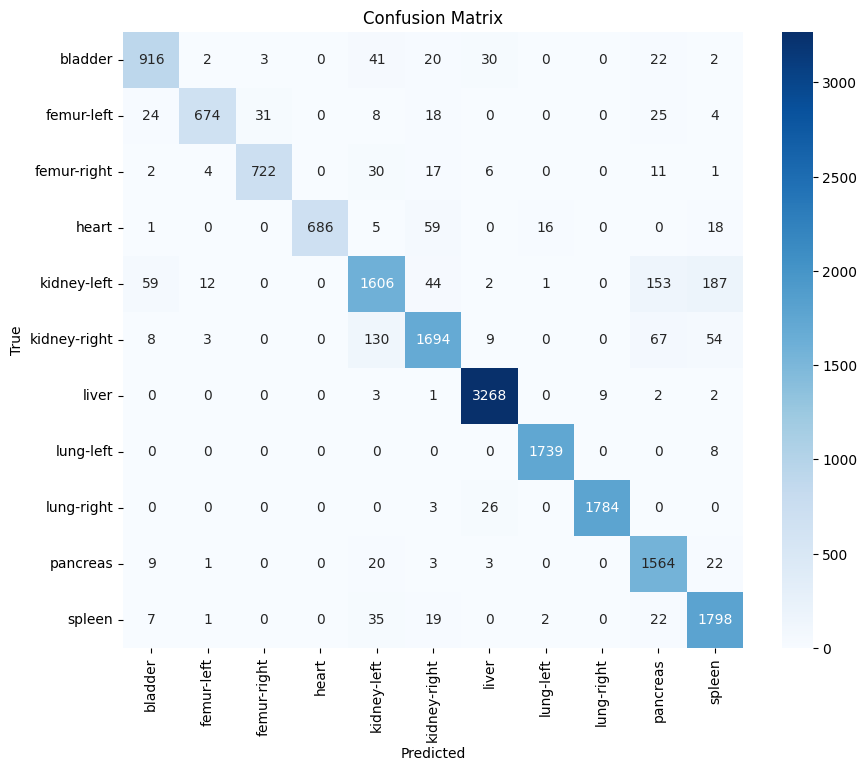

Model saved to resnet18_organamnist3.pt
model training n4


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/32842 (0%)]	Loss: 2.882250
Train Epoch: 1 [1280/32842 (4%)]	Loss: 0.579050
Train Epoch: 1 [2560/32842 (8%)]	Loss: 0.281979
Train Epoch: 1 [3840/32842 (12%)]	Loss: 0.301039
Train Epoch: 1 [5120/32842 (16%)]	Loss: 0.392799
Train Epoch: 1 [6400/32842 (20%)]	Loss: 0.200946
Train Epoch: 1 [7680/32842 (23%)]	Loss: 0.311159
Train Epoch: 1 [8960/32842 (27%)]	Loss: 0.124720
Train Epoch: 1 [10240/32842 (31%)]	Loss: 0.197883
Train Epoch: 1 [11520/32842 (35%)]	Loss: 0.133585
Train Epoch: 1 [12800/32842 (39%)]	Loss: 0.134046
Train Epoch: 1 [14080/32842 (43%)]	Loss: 0.222276
Train Epoch: 1 [15360/32842 (47%)]	Loss: 0.131803
Train Epoch: 1 [16640/32842 (51%)]	Loss: 0.079236
Train Epoch: 1 [17920/32842 (55%)]	Loss: 0.120043
Train Epoch: 1 [19200/32842 (59%)]	Loss: 0.099385
Train Epoch: 1 [20480/32842 (62%)]	Loss: 0.120647
Train Epoch: 1 [21760/32842 (66%)]	Loss: 0.158372
Train Epoch: 1 [23040/32842 (70%)]	Loss: 0.144253
Train Epoch: 1 [24320/32842 (74%)]	Loss: 0.093760
Train Epoch: 1

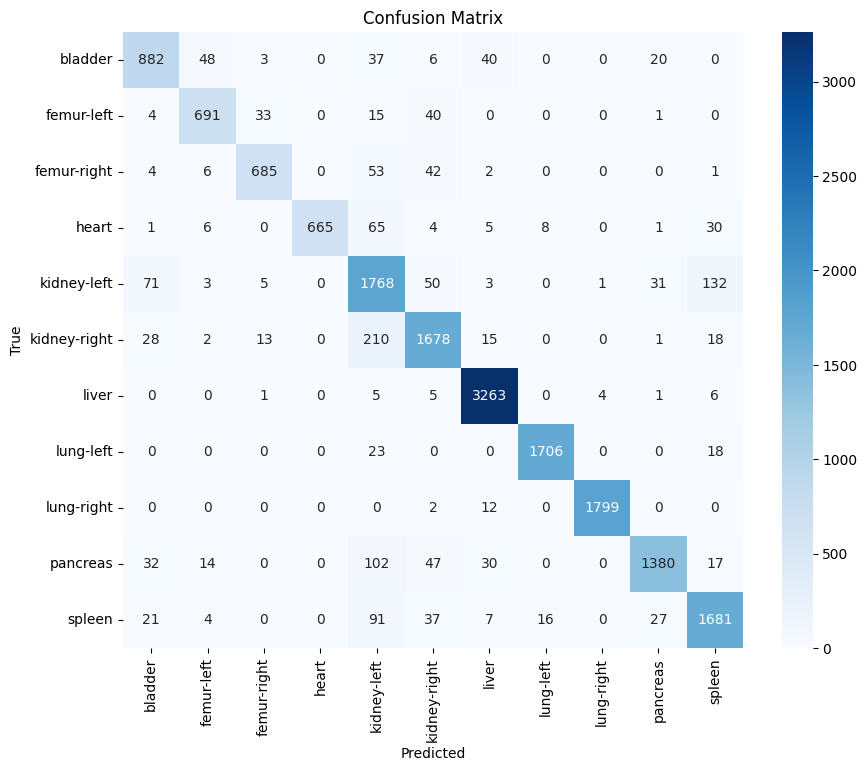

Model saved to resnet18_organamnist4.pt


In [10]:
for i, (train_loader, val_loader) in enumerate(zip(train_loaders, val_loaders)):    
    print('model training n' + str(i))
    num_classes = len(info['label'])
    model = ResNet18(num_classes=num_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)


    # Training settings
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    def train(model, device, train_loader, optimizer, criterion, epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.squeeze().long())
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    def validate(model, device, val_loader, criterion):
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target.squeeze().long()).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n')

    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        validate(model, device, val_loader, criterion)
        
    # Evaluate the model
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_true.extend(target.cpu().numpy().flatten())
            y_score.extend(output.cpu().numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    evaluator = Evaluator(data_flag, 'test')
    auc, acc = evaluator.evaluate(y_score)
    print(f'AUC: {auc:.3f}, Accuracy: {acc:.3f}')

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_score.argmax(axis=1))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the trained model
    model_path = f'resnet18_organamnist{i}.pt'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')


/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Ensemble AUC: 0.997, Ensemble Accuracy: 0.944


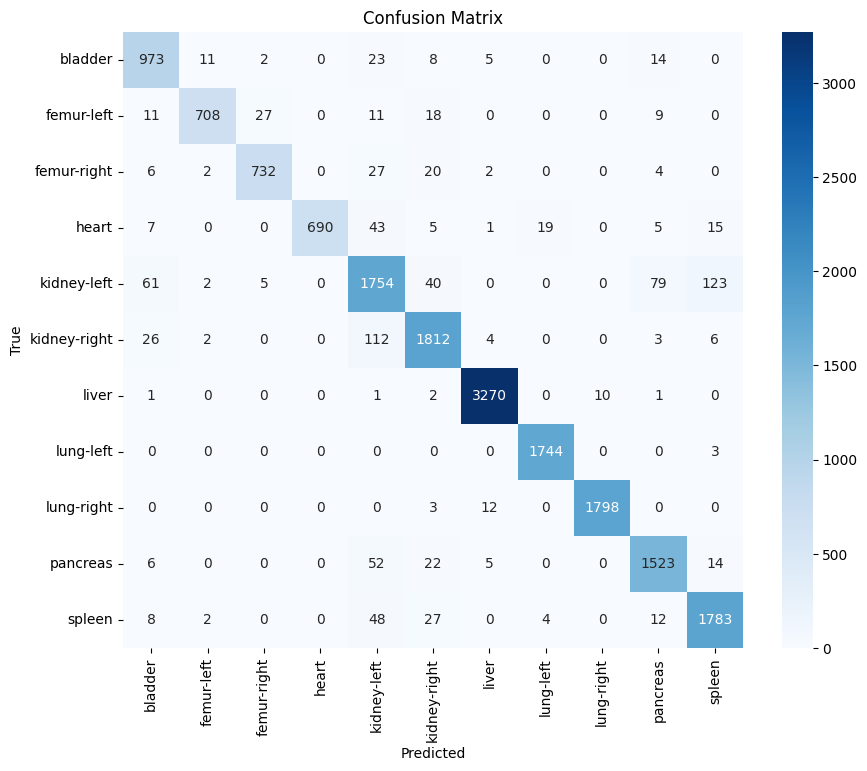

In [ ]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

# Perform inference on the test set
y_true = []
y_scores = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Evaluate the ensemble model
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_scores)
print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

# Generate the confusion matrix

cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))
print(f'Balanced Accuracy: {balanced_acc:.3f}')

Balanced Accuracy: 0.935
